# **tSDRG Data Analysis**

### 1. **Before start plotting, please change the file path "my_metadata_file = ..." to your own metadata directory.**
### &emsp;*By defalt is for dropbox path.*
### 2. **Dim / Jdis = Dimerization / Randomness strength** 

### 3. **DimABC / JdisABC = Dimerization A.BC / Randomness strength A.BC**
### &emsp;*example: Dim123 = Dimerization 1.23*

# **Define metadata directory path**

In [ ]:
## ------------------------------------------ Please change blow path to your own metadata directory path ------------------------------------------
my_metadata_file = '../tSDRG_metadata/Spin2/metadata/' ## Your local path (not necessary)
# my_metadata_file = './Spin2_metadata/' ## Defalt

# **Import lib and set basic parameter**

In [ ]:
## Import library
import os
import math
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

In [ ]:
## Basic parameter
cnames = {                        
'blueviolet':           '#8A2BE2',
'burlywood':            '#DEB887',
'cadetblue':            '#5F9EA0',
'crimson':              '#DC143C',
'cyan':                 '#00FFFF',
'darkblue':             '#00008B',
'darkorange':           '#FF8C00',
'dimgray':              '#696969',
'dodgerblue':           '#1E90FF',
'firebrick':            '#B22222',
'fuchsia':              '#FF00FF',
'gainsboro':            '#DCDCDC',
'gold':                 '#FFD700',
'greenyellow':          '#ADFF2F',
'hotpink':              '#FF69B4',
'indianred':            '#CD5C5C',
'indigo':               '#4B0082',
'ivory':                '#FFFFF0',
'khaki':                '#F0E68C',
'orangered':            '#FF4500',
'orchid':               '#DA70D6'}
carr = []
for cmap in cnames.keys():                          ## color array
    carr.append(cmap)
marr = ['o-', '^-', 'x-', 's-', 'p-', '*-', 'h-']   ## marker array
marr_nl = ['o', '^', 'x', 's', 'p', '*', 'h']       ## marker array (no line)

spin = int(2)                                       ## Spin type
BC = 'PBC'                                          ## Boundary condition
P = 10                                              ## Random distribution type (10 == Exponential distribution)
M = 40                                              ## Bound dimension 
font_size = 30

ALL_Dimer = ["Dim000"]
ALL_Jdis = ["Jdis000"]

Ddiff = 1
init_D = 0      ## Dim000 = 0.00
final_D = 100   ## Dim100 = 1.00
ds = (final_D - init_D)/Ddiff-1
for i in range (int(ds)+1):
    strD = "Dim00" + str((i+1)*Ddiff+init_D)
    if ((i+1)*Ddiff+init_D >= 10):
        strD = "Dim0" + str((i+1)*Ddiff+init_D)
    if ((i+1)*Ddiff+init_D >= 100):
        strD = "Dim" + str((i+1)*Ddiff+init_D) 
    ALL_Dimer.append(strD)

Jdiff = 1
init_J = 0      ## Jdis000 = 0.00
final_J = 600   ## Jdis600 = 6.00
js = (final_J - init_J)/Jdiff-1
for i in range (int(js)+1):
    strJ = "Jdis00" + str((i+1)*Jdiff+init_J)
    if ((i+1)*Jdiff+init_J >= 10):
        strJ = "Jdis0" + str((i+1)*Jdiff+init_J)
    if ((i+1)*Jdiff+init_J >= 100):
        strJ = "Jdis" + str((i+1)*Jdiff+init_J)
    ALL_Jdis.append(strJ)
# print(ALL_Dimer) ## ALL_Dimer = [Dim000, Dim001, ... , Dim099, Dim100]
# print(ALL_Jdis)  ## ALL_Jdis = [Jdis000, Jdis001, ... , Jdis599, Jdis600]

# **Define function**

In [ ]:
def find_id(f_diff): ## find crossing point index
    ids = []
    for id in range(len(f_diff)-1):
        if (np.sign(f_diff['diff'][id]) != np.sign(f_diff['diff'][id+1])):
            ids.append(id)
    if (len(ids) == 0):
        raise ValueError('no crossing point')
    return ids

def fitting_point(f_L1, f_L2, ids, var, para, n_point):
    x = []
    y = []
    for id in ids:   
        id_range = range(id-int(n_point/2-1), id+int(n_point/2)) ## use n-1 point to fit (id-(n/2-1), ... id, ..., id+(n/2))

        a1, b1  = np.polyfit(f_L1[var][id_range], f_L1[para][id_range], 1)
        a2, b2  = np.polyfit(f_L2[var][id_range], f_L2[para][id_range], 1)
        x0 = (b2-b1)/(a1-a2)
        y0 = a1*x0 + b1
        x.append(x0)
        y.append(y0)
    return x

def fitting_point_slope(f_L1, f_L2, ids, var, para, n_point): ## return L1, L2 slope
    for id in ids:   
        id_range = range(id-int(n_point/2-1), id+int(n_point/2)) ## use n-1 point to fit (id-(n/2-1), ... id, ..., id+(n/2))

        a1, b1  = np.polyfit(f_L1[var][id_range], f_L1[para][id_range], 1)
        a2, b2  = np.polyfit(f_L2[var][id_range], f_L2[para][id_range], 1)
    return a1,a2

def fitting_point_second(f_L1, f_L2, ids, var, para, L_n_point, R_n_point): ## use second-degree polynomial to fit curve
    for id in ids:   
        id_range = range(id-L_n_point, id+R_n_point) ## use R_n_point - L_n_pointto fitz
        # print(f_L1[var][id_range])
        a1, b1, c1  = np.polyfit(f_L1[var][id_range], f_L1[para][id_range], 2)
        a2, b2, c2  = np.polyfit(f_L2[var][id_range], f_L2[para][id_range], 2)
        a = a1-a2 
        b = b1-b2
        c = c1-c2
        x1 = (-b + (b**2 - 4*a*c)**0.5)/(2*a)
        x2 = (-b - (b**2 - 4*a*c)**0.5)/(2*a)
    return x1,x2

# **Plot**

## Phase Diagram (old)

In [ ]:
## 以縱切得到的圖
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(30,15))

myfile = './PhaseDiagram_D-J.csv'
df1 = pd.read_csv(myfile)
ax[0].plot(df1['D'], df1['J'], '-o', color="red", markersize = font_size/3, label = 'Straight cut')
ax[0].plot(df1['D'], df1['J2'], '-o', color="red", markersize = font_size/3)
## 以橫切得到的圖
myfile = './PhaseDiagram_J-D.csv'
df2 = pd.read_csv(myfile)
ax[0].plot(df2['D'], df2['J'], '-o', color="blue", markersize = font_size/3, label = 'Crosscut')
ax[0].plot(df2['D2'], df2['J'], '-o', color="blue", markersize = font_size/3)

ax[0].set_xlabel(r'$D$', fontsize=30)
ax[0].set_ylabel(r'$J$', fontsize=30)
ax[0].tick_params(axis='x', labelsize=20) 
ax[0].tick_params(axis='y', labelsize=20)
ax[0].set_title('old', fontsize=30)
ax[0].grid(linestyle='-', linewidth=1)
# ax[0].set_xlim([0, 0.2])                  
# ax[0].set_ylim([0, 1])          
ax[0].legend(loc = 'best',fontsize=font_size*5/6)

## 以縱切得到的圖
myfile = './PhaseDiagram_D-J_new.csv'
df1 = pd.read_csv(myfile)
ax[1].plot(df1['D'], df1['J'], '-o', color="red", markersize = font_size/3, label = 'Straight cut')
ax[1].plot(df1['D'], df1['J2'], '-o', color="red", markersize = font_size/3)
## 以橫切得到的圖
myfile = './PhaseDiagram_J-D_new.csv'
df2 = pd.read_csv(myfile)
ax[1].plot(df2['D'], df2['J'], '-o', color="blue", markersize = font_size/3, label = 'Crosscut')
ax[1].plot(df2['D2'], df2['J'], '-o', color="blue", markersize = font_size/3)

ax[1].set_xlabel(r'$D$', fontsize=30)
ax[1].set_ylabel(r'$J$', fontsize=30)
ax[1].tick_params(axis='x', labelsize=20) 
ax[1].tick_params(axis='y', labelsize=20)
ax[1].set_title('new', fontsize=30)
ax[1].grid(linestyle='-', linewidth=1)
# ax[1].set_xlim([0, 0.2])                  
# ax[1].set_ylim([0, 1])               
ax[1].legend(loc = 'best',fontsize=font_size*5/6)

# plt.savefig( dimer + '_Spin'+ str(spin) +'_' + BC + '_P'+ str(P) +'_m'+ str(M) +'_Oz-Jdis.pdf', format='pdf', dpi=4000)
# plt.savefig('L'+ str(L) +'_Spin'+ str(spin) +'_' + BC + '_P'+ str(P) +'_m'+ str(M) +'_Oz-Jdis.pdf', format='pdf', dpi=4000)
plt.show()


## Contourf Plot

In [ ]:
col, row  = 11, 8
D = np.round(np.linspace(0, 1.0, num=col), 2)
J = np.round(np.linspace(0, 7.0, num=row), 2)
Ls = [16,32,48,64]
x, y = np.meshgrid(D,J)
z = [[0 for _ in range(col)] for _ in range(row)]
print(D)
print(J)

OrderPara = "SOP"
if (OrderPara == "SOP"):
    Para = "O^z"
    label = r'$O^z(r=L/2)$'
else:
    Para = "ZL"
    label = r'$ZL$'

for l in range(len(Ls)):
    L = Ls[l]

    for j in range(len(J)):
        if (len(str(J[j])) == 3):
            jdis = 'Jdis' + str(J[j])[0] + str(J[j])[2] + '0'
        if (len(str(J[j])) == 4):
            jdis = 'Jdis' + str(J[j])[0] + str(J[j])[2] + str(J[j])[3]
            
        for d in range(len(D)):
            if (len(str(D[d])) == 3):
                dimer = 'Dim' + str(D[d])[0] + str(D[d])[2] + '0'
            if (len(str(D[d])) == 4):
                dimer = 'Dim' + str(D[d])[0] + str(D[d])[2] + str(D[d])[3]

            myfile = my_metadata_file + OrderPara +'/'+ jdis +'/'+ dimer +'/PBC_L'+ str(L) +'_P'+ str(P) +'_m'+ str(M) +'_'+ OrderPara +'.csv'

            if (os.path.exists(myfile) == False): ## Some data is not ok, so we need to ignore it.
                # print(str(L) + "_" + jdis + "_" + dimer + " missing data")
                continue

            df = pd.read_csv(myfile)  

            if (OrderPara == "SOP"):
                z[j][d] = -1*df[Para][0]
            else:
                z[j][d] = df[Para][0]
    # print(z)

    fig = plt.figure(figsize=(20, 14))
    fig.add_subplot(1,1,1)
    levels = np.linspace(0, 0.5, 11)            ## 固定顏色條上下限跟切幾等分
    cs = plt.contourf(x, y, z, levels=levels)
    cb = plt.colorbar()                         ## 顯示顏色條
    cb.set_label(label, fontsize=font_size)
    plt.xticks(fontsize=font_size/1.5)
    plt.yticks(fontsize=font_size/1.5)
    # plt.xticks([])
    # plt.yticks([])
    plt.xlabel(r'$D$', fontsize=font_size)
    plt.ylabel(r'$J$', fontsize=font_size)
    plt.xlim(0,0.7)  
    # plt.ylim(0.0, 0.02)
    # plt.xscale('log')
    # plt.yscale('log')
    plt.grid(linestyle='-', linewidth=1)
    plt.title('spin = %s, $\chi$ = %d, L=%d' % (spin, M, L), fontsize=font_size)

# plt.savefig('圖四.png', format='png')
plt.show()

## $1/\nu^*$(crossing slope) v.s.  1/**<font color = red>L</font>**

In [ ]:
OrderPara = "ZL"

if (OrderPara == "SOP"):
    Para = "O^z"
    plt.ylabel(r'$O^z(r=L/2)$_diff', fontsize=font_size)
if (OrderPara == "ZL"):
    Para = "ZL"
    plt.ylabel(r'$ZL$_diff', fontsize=font_size)

Ls = [24,32,40,48,56,64,72,80,88,96,128,256]
# Ls = [24,32,40,48,56,64]
Jdis = ["Jdis050"]
Dimer = ALL_Dimer[40:66]
n_point = 4

for j in range(len(Jdis)):
    jdis = Jdis[j]
    J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])
    S_L1 = []
    S_L2 = []

    for l in range(len(Ls)-1):
        L1 = Ls[l]
        L2 = Ls[l+1]
        f_L1 = pd.DataFrame(columns = ['Dimer', 'ZL'])
        f_L2 = pd.DataFrame(columns = ['Dimer', 'ZL'])
        f_diff = pd.DataFrame(columns = ['Dimer', 'diff'])
        ignore_num = 0

        for d in range(len(Dimer)):
            dimer = Dimer[d]
            D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])
        
            file_L1 = my_metadata_file + OrderPara +'/'+ jdis +'/'+ dimer +'/PBC_L'+ str(L1) +'_P'+ str(P) +'_m'+ str(M) +'_'+ OrderPara +'.csv'
            file_L2 = my_metadata_file + OrderPara +'/'+ jdis +'/'+ dimer +'/PBC_L'+ str(L2) +'_P'+ str(P) +'_m'+ str(M) +'_'+ OrderPara +'.csv'
            
            if (os.path.exists(file_L1) == False or os.path.exists(file_L2) == False): # Some data is not ok, so we need to ignore it.
                ignore_num += 1
                continue
        
            df_L1 = pd.read_csv(file_L1)
            df_L2 = pd.read_csv(file_L2)

            if (OrderPara == "SOP"):
                mean_L1 = {'Dimer':D, 'ZL':-df_L1[Para][0]}
                mean_L2 = {'Dimer':D, 'ZL':-df_L2[Para][0]}
                mean_diff = {'Dimer':D, 'diff':df_L1[Para][0]-df_L2[Para][0]}
            else:
                mean_L1 = {'Dimer':D, 'ZL':df_L1[Para][0]}
                mean_L2 = {'Dimer':D, 'ZL':df_L2[Para][0]}
                mean_diff = {'Dimer':D, 'diff':df_L2[Para][0]-df_L1[Para][0]}

            f_L1.loc[d-ignore_num] = mean_L1
            f_L2.loc[d-ignore_num] = mean_L2
            f_diff.loc[d-ignore_num] = mean_diff

        ids = find_id(f_diff)
        S1, S2 = fitting_point_slope(f_L1, f_L2, ids, "Dimer", Para, n_point)
        S_L1.append(S1)
        S_L2.append(S2)
        
    print(S_L1, S_L2)

    x = []
    y = []

    for l in range(len(S_L1)):
        x.append(Ls[l]**-1)
        y.append(np.log(S_L1[l]/S_L2[l]) / np.log(Ls[l]/Ls[l+1]))
        
    print(x)
    print(y)
    plt.plot(x, y, "o-", markersize = font_size/3, linewidth = font_size/15)

    # a, b  = np.polyfit(x, y, 1)
    # fit_x = x.copy()
    # fit_x.append(0)
    # fit_y = [i * a + b for i in fit_x]
    # print(b)
    # plt.plot(fit_x, fit_y, "--", markersize = font_size/3, linewidth = font_size/15)

# plt.xscale('log')
# plt.yscale('log')
plt.xticks(fontsize=font_size/1.5)
plt.yticks(fontsize=font_size/1.5)
plt.ylabel(r'$1/\nu^*$', fontsize=font_size)
plt.xlabel(r'$1/L$', fontsize=font_size)
plt.xlim(0, 0.05)
plt.ylim(0, 6)
plt.grid(linestyle='-', linewidth=1)
plt.title('spin = %s, $\chi$ = %d, Jdis = %.2f' % (spin, M, J), fontsize=font_size)
# plt.legend(bbox_to_anchor=(1, 1), loc = 'best',fontsize=font_size*5/6)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

## $C_1(L)$ v.s.  **<font color = red>L</font>**

In [ ]:
def func(x, a, b):
    return a/(x**b)

OrderPara = "EndtoEnd"
Ls = [16,32,48,64]
Dimer = ["Dim000"]
# Dimer = ["Dim000","Dim005","Dim010","Dim015","Dim020","Dim030","Dim040","Dim050","Dim055","Dim060","Dim065"]
Jdis = ["Jdis020","Jdis040","Jdis060","Jdis070","Jdis080","Jdis090","Jdis100"]

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(20,10))

for d in range(len(Dimer)):
    dimer = Dimer[d]
    D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])

    for j in range(len(Jdis)):
        jdis = Jdis[j]
        J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])
        dfplt = pd.DataFrame(columns = ['L', 'corr', 'error'], dtype=float)  

        for l in range(len(Ls)):
            L = Ls[l]
             
            myfile = my_metadata_file + OrderPara +'/'+ jdis +'/'+ dimer +'/OBC_L'+ str(L) +'_P'+ str(P) +'_m'+ str(M) +'_Corr.csv'
            if (os.path.exists(myfile) == False): # Some data is not ok, so we need to ignore it.
                # print(dimer + ' does not exist!!!')
                continue
            
            df = pd.read_csv(myfile)
            mean = {'L':L, 'corr':df['corr'][0], 'error':df['error'][0]}
            dfplt.loc[l] = mean

        if (dfplt.empty):
            continue

        popt, pcov = curve_fit(func, dfplt['L'], dfplt['corr'])
        a = popt[0] 
        b = popt[1]
        yvals = func(dfplt['L'],a,b)
        ax.plot(dfplt['L'], yvals, '--', color=carr[j], markersize = 15, label = 'A/$L^{%.4f}$,for J=%.2f' %(b, J))

        ax.plot(dfplt['L'], dfplt['corr'], marr[int(j/7)], color=carr[j], markersize = 15)
        ax.errorbar(dfplt['L'], dfplt['corr'], yerr=dfplt['error'], linestyle='None', capsize=20, capthick=2, color=carr[j], label=None)
        ax.set_xlabel('L', fontsize=30)
        ax.set_ylabel(r'$C_{1}(L)$', fontsize=30)
        
        ax.set_title(r"D = %.2f" %(D), fontsize=25)

        # ax.set_xlim([0,65])
        # ax.set_ylim([0, 4])
        ax.legend(loc = 'best',fontsize=20)

ax.set_xscale('log')
ax.set_yscale('log')  
ax.grid(which='major', linestyle='-')
ax.tick_params(labelsize=20) 
fig.suptitle('spin = %s, $\chi$ = %d' % (spin, M), fontsize=30)
# plt.savefig('L'+ str(L) +'_Spin'+ str(spin) +'_' + BC + '_P'+ str(P) +'_m'+ str(M) +'_Oz-D.pdf', format='pdf', dpi=4000)
plt.show() 

## Dimer correlation & Staggered Dimer correlation

       r      corr     error
0    1.0 -0.227588  0.047928
1    2.0 -0.141177  0.032265
2    3.0 -0.180605  0.045908
3    4.0 -0.156781  0.034025
4    5.0 -0.179125  0.045191
5    6.0 -0.157931  0.034504
6    7.0 -0.177405  0.044803
7    8.0 -0.159662  0.035525
8    9.0 -0.176120  0.043957
9   10.0 -0.160783  0.036065
10  11.0 -0.175437  0.043197
11  12.0 -0.160797  0.036323
12  13.0 -0.175999  0.043371
13  14.0 -0.160105  0.036492
14  15.0 -0.177497  0.043921
       r      corr
0    2.0  0.062920
1    3.0  0.031626
2    4.0  0.023083
3    5.0  0.021769
4    6.0  0.020334
5    7.0  0.018608
6    8.0  0.017101
7    9.0  0.015898
8   10.0  0.014996
9   11.0  0.014647
10  12.0  0.014921
11  13.0  0.015548
12  14.0  0.016642


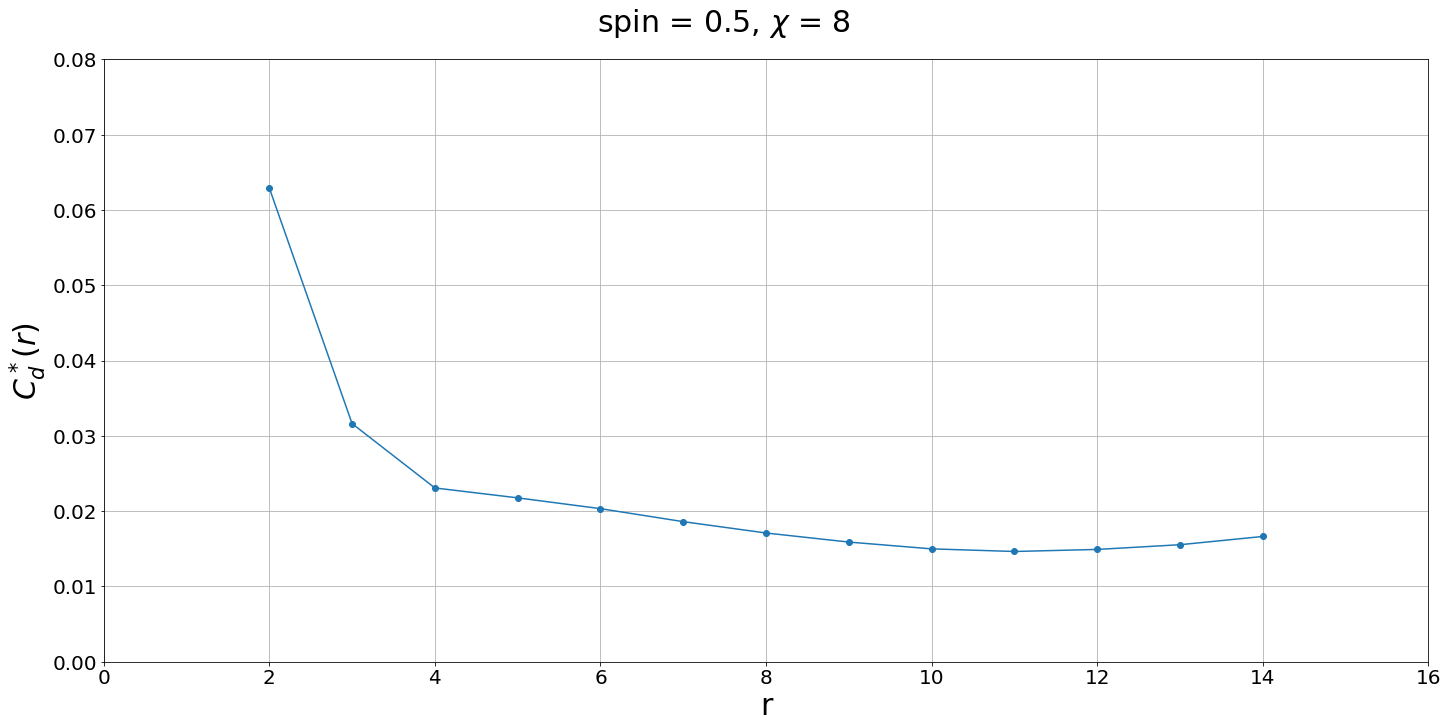

In [73]:
# myfile = "./dimer_corr_OBC.csv"
myfile = "./dimer_corr_PBC.csv"
df = pd.read_csv(myfile)
Dimer_corr = pd.DataFrame(columns = ['r', 'corr', 'error'], dtype=float) 
Stag_Dimer_corr = pd.DataFrame(columns = ['r','corr'], dtype=float)
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(20,10))

for i in range(16-1):
    r = i+1                          ## C_d(r) 從 r = 1 開始到 L/2
    filt = (df['x2'] - df['x1'] == r)
    mean = {'r':r, 'corr':df.loc[filt]['corr2'].mean(), 'error':df.loc[filt]['corr2'].sem()}
    Dimer_corr.loc[i] = mean
print(Dimer_corr)

for j in range(16-3):                ## C_d^star(r) 從 r = 2 開始到 L/2 - 2
    r = j+2
    a = Dimer_corr.loc[Dimer_corr['r'] == r]['corr'].mean()
    b = 0.5*Dimer_corr.loc[Dimer_corr['r'] == r-1]['corr'].mean()
    c = 0.5*Dimer_corr.loc[Dimer_corr['r'] == r+1]['corr'].mean()

    SDC = pow(-1, r)*(a-b-c)
    mean = {'r':r, 'corr':SDC}
    Stag_Dimer_corr.loc[j] = mean
print(Stag_Dimer_corr)

ax.plot(Stag_Dimer_corr['r'], Stag_Dimer_corr['corr'], marr[0])

ax.set_xlabel('r', fontsize=30)
ax.set_ylabel(r'$C_{d}^*(r)$', fontsize=30)
ax.set_xlim([0, 16])
ax.set_ylim([0, 0.05])
ax.set_ylim([0, 0.08])
ax.grid(which='major', linestyle='-')
ax.tick_params(labelsize=20) 
fig.suptitle('spin = 0.5, $\chi$ = 8', fontsize=30)

plt.show()